# Multi-observable ODMD Utilities
from https://github.com/QuantumComputingLab/odmd/blob/main/python/Excited%20state/TFIM_model_1D_excited_state.ipynb

In [ ]:
from __future__ import division
import numpy as np, functools as ft
from pylab import cm
from matplotlib import pyplot as plt, cm as cm
from scipy.linalg import svd,eig,eigh,norm,toeplitz

###### Pauli and Hadmard gates ######
I, X, Y, Z = np.eye(2), np.array([[0, 1], [1, 0]]), np.array([[0, -1j], [1j, 0]]), np.array([[1, 0], [0, -1]])
Hd = np.array([[1, 1], [1, -1]])/np.sqrt(2)

###### Scaling factor for Hamiltonian with spectrum in [-a, a] ######
a = 3*np.pi/4

def scale(E):
    """
    Scale the Hamiltonian spectrum.

    Parameters:
    - E: Energy spectrum of Hamiltonian (E_0, E_1, ..., E_{Hilbert space dimension})
    
    Returns:
    - Scaled energy spectrum in [-a, a] for a < π
      Rescaling factor for proper conversion of final energy estimate
    """
    
    E_center = E - (E.min()+E.max())/2
    return a*E_center/np.abs(E_center).max(), np.abs(E_center).max()/a

def S_gen(ref_state, time_grid, E, eps=0):
    """
    Generate an overlap trajectory <ɸ|exp(-iHt)|ɸ>.

    Parameters:
    - time_grid: General time grid (t_0 = 0, t_1, ..., t_{NT_max-1})
    - E: Energy spectrum of Hamiltonian
    - eps: Standard deviation of gaussian noises on matrix elements
    
    Returns:
    - S: Overlap trajectory [s(t0), s(t1), ...]
    """
    T = len(time_grid)
    S = np.zeros((2, T))
    for t in range(T):
        phases_t = np.exp(-1j * E * time_grid[t])
        overlap = np.sum(phases_t * ref_state**2)
        S[0,t], S[1,t] = overlap.real, overlap.imag
    S[:,1:] = S[:,1:] + np.random.normal(0, eps, (2, T-1)) 
    return S

def state_ref(target_overlap, E):
    """
    Generate a reference state with prescribed eigenstate overlap.

    Parameters:
    - target_overlap: Prescribed overlaps (p_0, p_1, ..., p_{# target eigenstates})
    - E: Energy spectrum of Hamiltonian
    
    Returns:
    - state: reference state with specified overlaps on target eigenstates 
             and uniform overlap over remaining eigenstates
    """
    state = np.zeros(len(E))
    state[:len(target_overlap)] = np.sqrt(target_overlap)
    state[len(target_overlap):] = np.sqrt((1- np.sum(target_overlap))/(len(E)-len(target_overlap))) 
    return state

def Z_string(N, w=1):
    """
    Generate a random Pauli Z string with a given weight.

    Parameters:
    - N: System size
    - w: Weight of the Pauli string
    
    Returns:
    - random Pauli Z string with weight w
    """
    indices = np.random.choice(N, w, replace=False)
    Z_string = ft.reduce(np.kron, [Z if j in indices else I for j in range(N)])
    return Z_string

def X_string(N, w=1):
    """
    Generate a random Pauli X string with a given weight.
    """
    indices = np.random.choice(N, w, replace=False)
    X_string = ft.reduce(np.kron, [X if j in indices else I for j in range(N)])
    return X_string

def Y_string(N, w=1):
    """
    Generate a random Pauli Y string with a given weight.
    """
    indices = np.random.choice(N, w, replace=False)
    Y_string = ft.reduce(np.kron, [Y if j in indices else I for j in range(N)])
    return Y_string

###### H = - sum_{i} Z_{i}*Z_{i+1} + h*Z_{i} + g*X_{i} ######
def H_MFIM(N, h, g, ref_state_Zbasis, O_Zbasis):
    """
    Construct 1D TFIM Hamiltonian.
    
    Parameters:
    - N: System size
    - h: Strength of longitudinal field 
    - g: Strength of transverse field
    - ref_state_Zbasis: reference state in the computational basis
    - O_Zbasis: additional operators in the computational basis
                used in multi-observable ODMD and multi-reference UVQPE 
    
    Returns:
    - eigval: Exact spectrum of TFIM Hamiltonian
    - eigvec.T @ vec_Zbasis: refence state in the eigenbasis (note that eigenstates of TFIM are real-valued)
    - [eigvec.T @ O @ vec_Zbasis for O in O_Zbasis]: action of additional operators on reference state, 
                                                     expressed in eigenbasis
    """
    
    H = np.zeros((2**N, 2**N), dtype=complex)
    
    # Loop over individual spin sites
    for i in range(N):
        nn_list = [Z if j == i or j == (i+1)%N else I for j in range(N)]     # Z_i Z_{i+1} 
        H += -ft.reduce(np.kron, nn_list)
        Z_list = [Z if j == i else I for j in range(N)]                      # Z_i
        X_list = [X if j == i else I for j in range(N)]                      # X_i
        H += -h * ft.reduce(np.kron, Z_list) -g * ft.reduce(np.kron, X_list)
    
    for i in H:
        for j in i:
            print(j, end = '\t')
        print()
    # Eigenvals and eigenvecs of MFIM in ascending order
    eigval, eigvec = eigh(H)
    print(eigval, eigvec)
    vec_Zbasis = ref_state_Zbasis.reshape((2**N, 1))        
    return eigval, eigvec.T @ vec_Zbasis, [eigvec.T @ O @ vec_Zbasis for O in O_Zbasis]

def BHankel(data):
    """
    Construct a block Hankel matrix from input data.
    
    Parameters:
    - data: Input data matrix (rows are variables, columns are time snapshots)
    - m: Block size for the Hankel matrix
    
    Returns:
    - H: Block Hankel matrix
    """
    rows, cols = data.shape
    m = cols//3

    # Initialize the Hankel matrix
    X = np.zeros((rows * m, cols + 1 - m), dtype=complex)

    # Loop through each column and fill the matrix
    for i in range(cols + 1 - m):
        temp = data[:, i:i + m].T
        X[:, i] = temp.ravel()  # Flatten temp and store in X
    return X

def MODMD(data, dt, tol=1E-8, eigid=0):
    """
    Run multi-observable ODMD with SVD truncation.
    
    Parameters:
    - data: Input data matrix (each column is a snapshot in time)
    - dt: Time between data snapshots
    - tol: Tolerance for rank truncation
    - eigid: Number of eigenvalues to return
    
    Returns:
    - E_approx: Approximate eigenenergies as the sorted imaginary part of ODMD eigenvalues
    """
    
    # Shifted data matrices (block Hankel)
    X = BHankel(data)
    X1 = X[:, :-1]
    X2 = X[:, 1:]
    print(X1, X2)
    
    # SVD of X1
    U, S, Vh = svd(X1, full_matrices=False)
    
    # Rank truncation
    r = np.sum(S > tol * S[0])
    U = U[:, :r]
    S = S[:r]
    V = Vh[:r, :].conj().T
    S_inv = np.diag(1/S) 
    
    # DMD computation
    Atilde = np.dot(np.dot(U.T, X2), np.dot(V, S_inv))
    
    # Eigenvalue computation
    mu = eig(Atilde)[0]
    omega = np.log(mu) / dt
    Etilde = np.sort(-np.imag(omega))
    
    # Return the approximate eigenvalues
    return Etilde[eigid]

# Multi-reference UVQPE Utilities

In [39]:
def unit(state):
    """
    Normalize a state.
    """
    return state/norm(state)

def Block(ref_state, alpha, beta, phases, T):
    """
    Construct matrix blocks for a reference state pair in multi-reference UVQPE.
    
    Parameters:
    - ref_state: 2d array of reference states [ref_state[:,0], ref_state[:,1], ..., ref_state[:,D-1]]
                 where D is the total number of reference states
    - alpha: Index of the first reference state ref_state[:,alpha]
    - beta: Index of the second reference state ref_state[:,beta]
    - phases[l,n] = exp(-iE_n*ldt): 2d array of exact eigenphases
    
    Returns:
    - Toeplitz matrix blocks U(alpha,beta)_{jk} = <ɸ_alpha|exp(iHjdt)exp(-iHdt)exp(-iHkdt)|ɸ_beta>_{jk} and
                             S(alpha,beta)_{jk} = <ɸ_alpha|exp(iHjdt)exp(-iHkdt)|ɸ_beta>_{jk} 
    """

    r1, r2 = ref_state[:, alpha], ref_state[:, beta]
    rU, cU = np.zeros(T, dtype=complex), np.zeros(T, dtype=complex)
    rS, cS = np.zeros(T, dtype=complex), np.zeros(T, dtype=complex)
        
    for t in range(T):
        rU[t], cU[t] = np.vdot(r1, phases[1]*phases[t]*r2), np.vdot(phases[t]*r1, phases[1]*r2)
        rS[t], cS[t] = np.vdot(r1, phases[t]*r2), np.vdot(phases[t]*r1, r2)
    return toeplitz(cU, rU), toeplitz(cS, rS)

def MatU(ref_state, tgrid, E, eps):
    
    """
    Construct full noisy matrices in multi-reference UVQPE from the matrix blocks.
    
    Parameters:
    - ref_state: 2d array of reference states [ref_state[:,0], ref_state[:,1], ..., ref_state[:,D-1]]
                 where D is the total number of reference states
    - tgrid[l] = l*dt: 1d array of timegrid
    - E: Energy spectrum of Hamiltonian
    - eps: Standard deviation of gaussian noises on matrix elements
    
    Returns:
    - Toeplitz matrices U_{(alpha,j),(beta,k)} = <ɸ_alpha|exp(iHjdt)exp(-iHdt)exp(-iHkdt)|ɸ_beta>_{jk} + eps_{jk} and
                        S_{(alpha,j),(beta,k)} = <ɸ_alpha|exp(iHjdt)exp(-iHkdt)|ɸ_beta>_{jk} + eps_{jk}
                        where the addded noise eps_{jk} is shared among matrix elements that have identical values
    """

    Q, d = ref_state.shape
    phases, T = np.exp(-1j * E * tgrid[:,np.newaxis]), len(tgrid)
    U, S = np.zeros((d*T, d*T), dtype=complex), np.zeros((d*T, d*T), dtype=complex)    
    r_eps, c_eps = np.zeros((d, d, T+1), dtype=complex), np.zeros((d, d, T), dtype=complex)

    for alpha in range(d):
        for beta in range(d):
            ro, co = alpha * T, beta * T
            ro_, co_ = ro + T, co + T
            U[ro:ro_, co:co_], S[ro:ro_, co:co_] = Block(ref_state, alpha, beta, phases, T)
            
            if alpha == beta:    
                
                rnoise = np.random.normal(0, eps, T+1) + 1j*np.random.normal(0, eps, T+1)
                rnoise[0] = 0
                
                Unoise = toeplitz(np.concatenate(([rnoise[1]], rnoise[:-2].conj())), rnoise[1:])
                Snoise = toeplitz(rnoise[:-1].conj(), rnoise[:-1])
                U[ro:ro_, co:co_] += Unoise 
                S[ro:ro_, co:co_] += Snoise
                r_eps[alpha, beta] = rnoise
                
            elif alpha < beta:
                
                rnoise = np.random.normal(0, eps, T+1) + 1j*np.random.normal(0, eps, T+1)
                rnoise[0] = 0
                cnoise = np.random.normal(0, eps, T-1) + 1j*np.random.normal(0, eps, T-1)
                
                Unoise = toeplitz(np.concatenate(([rnoise[1], rnoise[0]], cnoise[:-1])), rnoise[1:])
                Snoise = toeplitz(np.concatenate(([rnoise[0]], cnoise)), rnoise[:-1])
                U[ro:ro_, co:co_] += Unoise
                S[ro:ro_, co:co_] += Snoise
                r_eps[alpha, beta], c_eps[alpha, beta, :T-1] = rnoise, cnoise
                c_eps[alpha, beta, T-1:] = np.random.normal(0, eps) + 1j*np.random.normal(0, eps)
                
            elif alpha > beta:
                
                rnoise = r_eps[beta, alpha]
                cnoise = c_eps[beta, alpha]
                
                Unoise = toeplitz(np.concatenate(([cnoise[0]], rnoise[:-2])).conj(), cnoise.conj())
                Snoise = toeplitz(rnoise[:-1].conj(), np.concatenate(([rnoise[0]], cnoise[:-1])).conj())
                U[ro:ro_, co:co_] += Unoise
                S[ro:ro_, co:co_] += Snoise
    return U, S

def EigU(U, S, tol=1E-5, eigid=0):
    
    """
    Compute solution to the generalized eigenvalue problems of multi-reference UVQPE.
    
    Parameters:
    - U: Toeplitz matrix with entries 
         U_{(alpha,j),(beta,k)} = <ɸ_alpha|exp(iHjdt)exp(-iHdt)exp(-iHkdt)|ɸ_beta>_{jk} + eps_{jk}
    - S: Toeplitz matrix with entries
         S_{(alpha,j),(beta,k)} = <ɸ_alpha|exp(iHjdt)exp(-iHkdt)|ɸ_beta>_{jk} + eps_{jk}
         where noise eps_{jk} is shared among matrix elements that have identical values
    - tol: Relative threshold value for SVD thresholding
    - eigid: Index of the target eigenstate to be approximated
    
    Returns:
    - Approximate target eigenenergy (multiplied by unit timestep) estimated by UVQPE
    """
    sval, rot = eigh(S)
    trunc = 0
    for j in range(len(sval)):
        if sval[j] > tol * sval[-1]:
            trunc = j                                                             # singular value truncation 
            break
            
    ##### continue here ######
    Srot, Urot = rot[:, trunc:].conj().T @ S @ rot[:, trunc:], rot[:, trunc:].conj().T @ U @ rot[:, trunc:]
    eigval, eigvec = eig(Urot, Srot) 
    eigarg = -np.angle(eigval)
    return np.sort(eigarg)[eigid]


###### This is the main function to call for running multi-reference UVQPE ######
def UVQPE(ref_state, time_grid, time_grid_plot, E, eps, tol=1E-5, eigid=0):
    
    """
    Run multi-reference UVQPE to estimate a target eigenenergy.
    
    Parameters:
    - ref_state: 2d array of reference states [ref_state[:,0], ref_state[:,1], ..., ref_state[:,D-1]]
                 where D is the total number of reference states
    - time_grid[l] = l*dt: 1d array of timegrid
    - time_grid_plot: Sampled time grid for plotting purpose
    - E: Energy spectrum of Hamiltonian
    - eps: Standard deviation of gaussian noises on matrix elements
    - tol: Relative threshold value for SVD thresholding
    - eigid: Index of the target eigenstate to be approximated
    
    Returns:
    - Etilde: 1D array containing approximate eigenenergies evaluated over time_grid_plot
    """

    Etilde, dt = np.zeros(len(time_grid_plot)), time_grid[1] 
    
    for _ in range(len(time_grid_plot)):
        t_plot = time_grid_plot[_]
        U, S = MatU(ref_state, time_grid[:t_plot], E, eps)
        Etilde[_] = EigU(U, S, tol, eigid)/dt
    return Etilde

# Numerical Experiments for TFIM (Fig. 8)

In [40]:
# ====== Generate linear time grid ======
# T: number of time steps
# dt: unit timestep
T, dt = 200, 1                    
time_grid = dt*np.arange(T)
tgrid_plot = np.arange(3, T, 2)

time_grid_odmd = dt*np.arange(T)
tgrid_plot_odmd = np.arange(3, T, 2)

# ====== Set noise level ======
eps = 1E-6

## Compute spin Hamiltonian eigenvalues and eigenvectors

In [41]:
#====== TFIM parameters ======
# N_TFIM: number of sites
# h: longitudinal field
# g: transverse field
# up_Zbasis: |++...+>
# down_Zbasis: |--...->
N_TFIM, h, g = 4, 0, 1
up_Zbasis = ft.reduce(np.kron, [Hd @ np.array([1, 0]) for i in range(N_TFIM)])
down_Zbasis = ft.reduce(np.kron, [Hd @ np.array([0, 1]) for i in range(N_TFIM)])

# ====== Reference state preparation ======
# ref_state_Zbasis: [3|++...+> + 2|--...->]/sqrt(13)
ref_state_Zbasis = unit(3*up_Zbasis + 2*down_Zbasis)

# psi0_TFIM: additional reference states
E_TFIM, psi_TFIM, psiO_TFIM = H_MFIM(N_TFIM, h, g, ref_state_Zbasis, [Z_string(N_TFIM, 1), Y_string(N_TFIM, 1)])

# ====== Scale spectra ======
# Es_TFIM: scaled Hamiltonian spectrum
# alp_TFIM: rescaling factor for final energy conversion
Es_TFIM, alp_TFIM = scale(E_TFIM)

(-4+0j)	(-1+0j)	(-1+0j)	0j	(-1+0j)	0j	0j	0j	(-1+0j)	0j	0j	0j	0j	0j	0j	0j	
(-1+0j)	0j	0j	(-1+0j)	0j	(-1+0j)	0j	0j	0j	(-1+0j)	0j	0j	0j	0j	0j	0j	
(-1+0j)	0j	0j	(-1+0j)	0j	0j	(-1+0j)	0j	0j	0j	(-1+0j)	0j	0j	0j	0j	0j	
0j	(-1+0j)	(-1+0j)	0j	0j	0j	0j	(-1+0j)	0j	0j	0j	(-1+0j)	0j	0j	0j	0j	
(-1+0j)	0j	0j	0j	0j	(-1+0j)	(-1+0j)	0j	0j	0j	0j	0j	(-1+0j)	0j	0j	0j	
0j	(-1+0j)	0j	0j	(-1+0j)	(4+0j)	0j	(-1+0j)	0j	0j	0j	0j	0j	(-1+0j)	0j	0j	
0j	0j	(-1+0j)	0j	(-1+0j)	0j	0j	(-1+0j)	0j	0j	0j	0j	0j	0j	(-1+0j)	0j	
0j	0j	0j	(-1+0j)	0j	(-1+0j)	(-1+0j)	0j	0j	0j	0j	0j	0j	0j	0j	(-1+0j)	
(-1+0j)	0j	0j	0j	0j	0j	0j	0j	0j	(-1+0j)	(-1+0j)	0j	(-1+0j)	0j	0j	0j	
0j	(-1+0j)	0j	0j	0j	0j	0j	0j	(-1+0j)	0j	0j	(-1+0j)	0j	(-1+0j)	0j	0j	
0j	0j	(-1+0j)	0j	0j	0j	0j	0j	(-1+0j)	0j	(4+0j)	(-1+0j)	0j	0j	(-1+0j)	0j	
0j	0j	0j	(-1+0j)	0j	0j	0j	0j	0j	(-1+0j)	(-1+0j)	0j	0j	0j	0j	(-1+0j)	
0j	0j	0j	0j	(-1+0j)	0j	0j	0j	(-1+0j)	0j	0j	0j	0j	(-1+0j)	(-1+0j)	0j	
0j	0j	0j	0j	0j	(-1+0j)	0j	0j	0j	(-1+0j)	0j	0j	(-1+0j)	0j	0j	(-1+0j)	
0j	0j	0j	0j	0j	0j	(-1

In [42]:
scale(E_TFIM)

(array([-2.35619449e+00, -2.17683986e+00, -9.75967713e-01, -9.01676595e-01,
        -9.01676595e-01, -3.73486674e-01,  2.59727729e-15,  3.26622100e-15,
         3.42838190e-15,  4.23957018e-15,  3.73486674e-01,  9.01676595e-01,
         9.01676595e-01,  9.75967713e-01,  2.17683986e+00,  2.35619449e+00]),
 np.float64(2.2180901794226933))

In [43]:
# ====== Unpack additional reference states ======
# psi2_TFIM: Z_string(N_TFIM, 1)|ref_state_Zbasis>
# psi3_TFIM: Y_string(N_TFIM, 1)|ref_state_Zbasis>
psi2_TFIM, psi3_TFIM = psiO_TFIM

In [44]:
psi_TFIM, psi2_TFIM, psi3_TFIM = psi_TFIM.flatten(), psi2_TFIM.flatten(), psi3_TFIM.flatten()
print(np.real(psi_TFIM[:5]**2))
print(np.real(psi2_TFIM[:5]**2))
print(np.real(psi3_TFIM[:5]**2))

print(np.vdot(psi_TFIM, psi3_TFIM))
print(np.vdot(psi_TFIM, psi2_TFIM))
print(np.vdot(psi2_TFIM, psi3_TFIM))

[5.45608646e-01 7.70371978e-34 1.32060495e-01 3.08148791e-33
 7.70371978e-34]
[1.50992908e-31 2.40584762e-01 7.70371978e-34 2.98869360e-01
 4.72844859e-02]
[-1.56433660e-31 -7.74062743e-02 -8.13705402e-33 -4.72844859e-02
 -2.98869360e-01]
1.2965281765184668e-16j
(-2.5682524526205776e-16+0j)
1.734723475976807e-16j


## Multi-observable ODMD results

In [45]:
# ====== Generate MODMD trajectories ======
S_TFIM = S_gen(psi_TFIM, time_grid, Es_TFIM, eps)[0]
S2_TFIM = S_gen(psi2_TFIM, time_grid, Es_TFIM, eps)[0]
S3_TFIM = S_gen(psi3_TFIM, time_grid, Es_TFIM, eps)[0]

# data_TFIM: 2d array of multi-observable signals
data_TFIM, dataS_TFIM = np.vstack((S_TFIM, S2_TFIM, S3_TFIM)), S_TFIM.reshape((1, T))

# ====== Compute multi-observable ODMD energy estimates ======
# R: number of Gaussian noise realizations
# tol: relative SVD threshold 
# eigid: index of the target eigenstate to be approximated
R = 1
tol, eigid = 1E-5, 1
Emodmd_plot = np.zeros((len(tgrid_plot), R))

for _ in range(len(tgrid_plot)):
    t_plot = tgrid_plot[_]
    for r in range(R):
        temp = MODMD(data_TFIM[:,:t_plot], dt, tol, eigid)
        Emodmd_plot[_,r] = temp
        # print(temp)

In [46]:
S_gen(psi_TFIM, time_grid, Es_TFIM, eps)

array([[ 1.        , -0.50425451, -0.05953336,  0.43753312, -0.95571118,
         0.62061204,  0.14564917, -0.45737652,  0.84735046, -0.72220723,
        -0.15115515,  0.55280518, -0.73490055,  0.75280899,  0.07299799,
        -0.67099567,  0.68059405, -0.69547828,  0.04555933,  0.74654027,
        -0.71448804,  0.58195033, -0.13890012, -0.73762199,  0.81782402,
        -0.47505619,  0.15536551,  0.64917811, -0.93340946,  0.43395932,
        -0.08583877, -0.5301623 ,  0.99727183, -0.4814069 , -0.03119711,
         0.44644236, -0.97406225,  0.59113656,  0.13096673, -0.44435814,
         0.87662885, -0.7024141 , -0.15824952,  0.52506027, -0.75889833,
         0.7536584 ,  0.09794599, -0.64388619,  0.68602927, -0.71649933,
         0.01656717,  0.73506614, -0.69835704,  0.61150517, -0.12191091,
        -0.74813527,  0.78905276, -0.49678829,  0.1597806 ,  0.67585994,
        -0.90792203,  0.43584571, -0.10921706, -0.55824647,  0.98917271,
        -0.4623948 , -0.0017954 ,  0.460383  , -0.9

## Multi-reference UVQPE results

In [47]:
# # ====== Compute multi-reference UVQPE energy estimates ======
# # psiB_TFIM: 2d array of reference states
# psiB_TFIM = np.column_stack((psi_TFIM, psi2_TFIM, psi3_TFIM))
# tolvals = tol*np.array([1E-1, 1, 1E+1])
# Euvqpe_plot = np.zeros((len(tgrid_plot), len(tolvals), R))

# for r in range(R):    
#     for _ in range(len(tolvals)):
#         Euvqpe_plot[:,_,r] = UVQPE(psiB_TFIM, time_grid, tgrid_plot, Es_TFIM, eps, tolvals[_], eigid)

## Results from multi-observable ODMD vs multi-reference UVQPE

/tmp/ipykernel_2295863/2068560677.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='best', edgecolor='none', facecolor='none', fontsize=15)


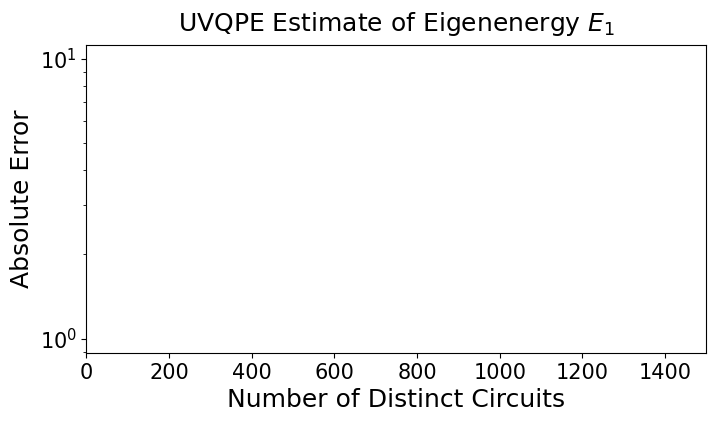

In [48]:
# ====== Plot multi-reference UVQPE energy estimates and their dependence on the SVD threshold ======
# duvqpe: scaling factor for total observable count, which scales quadratically with the number of reference states

# duvqpe = psiB_TFIM.shape[1]*psiB_TFIM.shape[1]*2

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
# for _ in range(len(tolvals)):
#     ax.plot(tgrid_plot*duvqpe, alp_TFIM*np.abs(Euvqpe_plot[:,_] - Es_TFIM[eigid]), label=r'$\tilde{\delta}/tol=%g$' % (tolvals[_]/tol))
    
ax.set_yscale('log')
ax.set_xlim([0, 1500])
ax.set_ylabel(r'Absolute Error', fontsize=18), ax.set_xlabel(r'Number of Distinct Circuits', fontsize=18)
ax.set_title(r'UVQPE Estimate of Eigenenergy $E_{%g}$' % eigid, fontsize=18, pad=10)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.legend(loc='best', edgecolor='none', facecolor='none', fontsize=15)

[ 1.18677358  0.8304503  -0.90209533 -1.36163455 -2.21771359 -2.17462628
 -2.17684104 -2.17683864 -2.17683919 -2.1768393  -2.17683974 -2.17683973
 -2.17683986 -2.17683976 -2.17683973 -2.17683969 -2.17683978 -2.17683974
 -2.17683973 -2.17683976 -2.17683978 -2.17683978 -2.17683977 -2.17683978
 -2.17683977 -2.17683979 -2.1768398  -2.1768398  -2.17683979 -2.1768398
 -2.1768398  -2.17683981 -2.17683981 -2.17683984 -2.17683985 -2.17683985
 -2.17683985 -2.17683985 -2.17683986 -2.17683986 -2.17683986 -2.17683986
 -2.17683986 -2.17683987 -2.17683985 -2.17683985 -2.17683985 -2.17683985
 -2.17683985 -2.17683984 -2.17683984 -2.17683984 -2.17683984 -2.17683984
 -2.17683984 -2.17683984 -2.17683984 -2.17683984 -2.17683984 -2.17683984
 -2.17683984 -2.17683984 -2.17683985 -2.17683984 -2.17683984 -2.17683985
 -2.17683985 -2.17683985 -2.17683985 -2.17683986 -2.17683985 -2.17683986
 -2.17683985 -2.17683986 -2.17683985 -2.17683985 -2.17683985 -2.17683985
 -2.17683985 -2.17683985 -2.17683985 -2.17683985 -2.

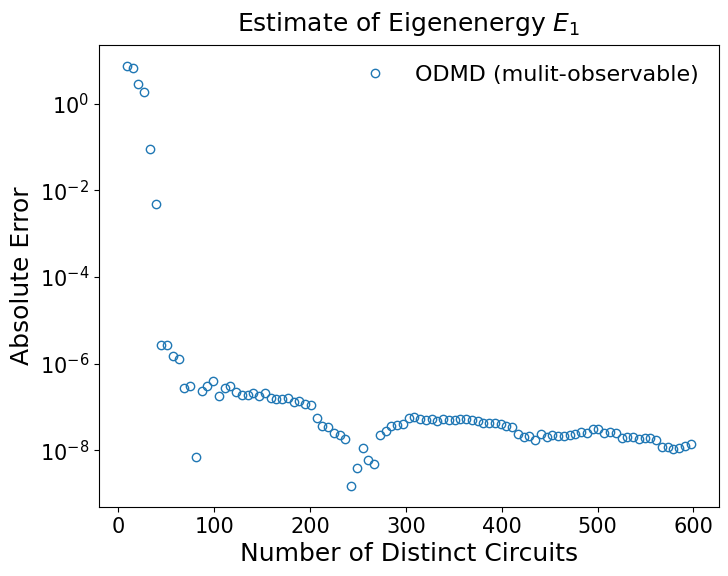

In [49]:
# ====== Plot multi-observable ODMD vs multi-reference UVQPE energy estimates ======

# duvqpe = psiB_TFIM.shape[1]*psiB_TFIM.shape[1]*2
Emodmd = np.mean(Emodmd_plot, axis=1)
print(Emodmd)
# Euvqpe = np.mean(Euvqpe_plot, axis=2)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(tgrid_plot*len(data_TFIM), alp_TFIM*np.abs(Emodmd - Es_TFIM[eigid]), 
        'o', mfc='none', label=r'ODMD (mulit-observable)')
# ax.plot(tgrid_plot*duvqpe, alp_TFIM*np.abs(Euvqpe[:,2] - Es_TFIM[eigid]), 
#         'o', mfc='none', label=r'UVQPE (mulit-reference)')

ax.set_yscale('log')
ax.set_ylabel(r'Absolute Error', fontsize=18), ax.set_xlabel(r'Number of Distinct Circuits', fontsize=18)
ax.set_title(r'Estimate of Eigenenergy $E_{%g}$' % eigid, fontsize=18, pad=10)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.legend(loc='best', edgecolor='none', facecolor='none', fontsize=16)